# Summary

This notebook serves as the testing environment of training the actor-critic model for preconditioner learning.

## TODO:
1. LOTS

# Imports/Setup

In [1]:
from Data import critic_dataset, dataset, generator
from Data import utility as data_utility
from Model import critics, actors, scipy, ddpg_training
from Model import utility as model_utility
from Evaluation import utility as eval_utility
from Objectives import losses, reward
import torch
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /data/users/jupyter-dam724/.local/lib/python3.9/site-packages/libpyg.so: undefined symbol: _ZN3c1010Dispatcher17runRecordFunctionERN2at14RecordFunctionESt17reference_wrapperIKNS_14FunctionSchemaEENS_11DispatchKeyE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred whil

# Configuration

In [2]:
class Config:
    # dataset
    device_pref = 'cuda'
    ind_dev = 2
    batch_size = 32
    n = 25
    train_len = 1000
    batch_size = 32
    gen_size = 5
    valid_len = 100
    shuffle = True

    
    # critic model
    pretrained_critic = '/data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/RUNS/critic_sigmoid_0.pth'
    down = 256  # if this is changed, model architecture should be changed as well
    sigmoid = True
    
    # actor model
    pretrained_actor = None
    hidden = 256 # 128 for LU (it doubles the amount of layers) | 512 for NID it has larger output same layers | 256 else
    sparse_tol = 1e-5
    diagonal_bias = 0.1
    
    l1 = 0
    inv = 0
    dev = 0
    cond = 1.0
    
    # training
    epoches = 100
    memory = 32*250
    wait = 64
    lr = 1e-5
    verbose = True

# Device

In [3]:
device = data_utility.set_device(Config.device_pref, Config.ind_dev)

Now using GPU.


# Critic

...

In [4]:
critic_params = {
    'n': Config.n, 
    'down': Config.down, 
    'batch_size': Config.batch_size, 
    'sigmoid_scale': Config.sigmoid
}

critic = critics.MultiCritic(**critic_params).to(device)

if Config.pretrained_critic is not None:
     model_utility.load_model(critic, Config.pretrained_critic)

## Cirtic Objective

...

In [5]:
reward_func = reward.batched_reward(Config.n, False)

In [6]:
critic_crit = losses.CriticMultiRewardLoss(1.0, 1.0, 1.0, reward_func)

# Actor

...

In [7]:
actor_params = {
    'n':Config.n,
    'hidden':Config.hidden,
    'batch_size':Config.batch_size,
    'sparse_tol':Config.sparse_tol,
    'diagonal_bias':Config.diagonal_bias
}

actor = actors.CholeskyFCN(**actor_params).to(device)

if Config.pretrained_actor is not None:
     model_utility.load_model(actor, Config.pretrained_actor)

# Actor (Additional) Objective

...

In [8]:
loss_params = {
    'l1': Config.l1,
    'inv': Config.inv,
    'dev': Config.dev,
    'cond': Config.cond,
    'batch_size': Config.batch_size,
    'size': Config.n
}

actor_crit = losses.CondEyeDistance(**loss_params)

# Dataset

...

In [9]:
train_dataset_params = {
    'generator': generator.generate_2d_diffusion_spd,
    'norm_feat': data_utility.normalize_features,
    'epoch_len': Config.train_len,
    'batch_size': Config.batch_size,
    'size': Config.gen_size
}

valid_dataset_params = {
    'generator': generator.generate_2d_diffusion_spd,
    'norm_feat': data_utility.normalize_features,
    'epoch_len': Config.valid_len,
    'batch_size': Config.batch_size,
    'size': Config.gen_size
}

train_dataset = dataset.SystemDataset(**train_dataset_params)
valid_dataset = dataset.SystemDataset(**valid_dataset_params)

In [10]:
train_dataloader_params = {
    'dataset': train_dataset,
    'batch_size': Config.batch_size,
    'shuffle': Config.shuffle
}

valid_dataloader_params = {
    'dataset': valid_dataset,
    'batch_size': Config.batch_size,
    'shuffle': Config.shuffle
}

train_dataloader = dataset.get_dataloader(**train_dataloader_params)
valid_dataloader = dataset.get_dataloader(**valid_dataloader_params)

In [11]:
A, b = next(iter(train_dataloader))

Determinent: 217056736.0
Matrix is non-singular.
Condition: 7560.609375
SPD


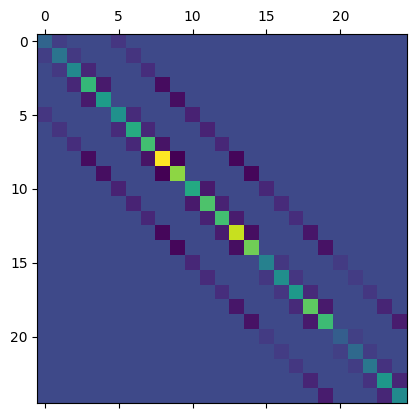

In [12]:
ind = 0
fig, ax = plt.subplots(1, 1)

data_utility.check_singularity(A, ind)
data_utility.check_conditioning(A, ind)
data_utility.view_matrix(A, ind, ax)
print('SPD') if data_utility.is_spd(A, ind) else print('Non-SPD')

# DDPG (Contextual Bandits)

...

In [13]:
def step(timestep, actor, critic, batch, critic_crit, actor_crit, buffer, wait, critic_optimizer, actor_optimizer, verbose):
    A, b = batch
    A, b = A.to(device), b.to(device)
    batch_size, n_size = A.shape[0], A.shape[1]
    A = A.view(batch_size, n_size**2)
    
    actor_out = actor(A)
    
    actor_update, critic_update = None, None
    
    if timestep != 0 and timestep % wait == 0:
        model_utility.unfreeze(critic)
        c_loader = tqdm(range(wait), desc=f'Critic-Train', leave=False, mininterval=2.0) if verbose else range(wait)
        
        accumulation_steps = 4
        critic_optimizer.zero_grad()   
        
        for batch_idx, _ in enumerate(c_loader):
            A, M, b = random.sample(buffer, 1)[0]
            A, M, b = A.to(device), M.to(device), b.to(device)
            inp = torch.concat([A, M], dim=1)
            out = critic(inp)
            
            sarse  = out[:, 0].view(batch_size, 1)
            niter = out[:, 1].view(batch_size, 1)
            residuals = out[:, 2].view(batch_size, 1)

            critic_update = critic_crit(sarse, niter, residuals, A.view(batch_size, n_size, n_size), M.view(batch_size, n_size, n_size), b)
                                
            if verbose:
                c_loader.set_postfix(critic_updates=critic_update.item())
                
            critic_update = critic_update / accumulation_steps 
            critic_update.backward()  
            if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(c_loader):
                critic_optimizer.step()
                critic_optimizer.zero_grad()      
        
    else:
        model_utility.freeze(critic)
        actor_out = actor_out.view(batch_size, n_size**2)
        A_out = torch.concat([A, actor_out], dim=1)
        critic_out = critic(A_out)
        weights = torch.Tensor([1.0, 1.0, 1.0]).to(device)
        
        actor_update = torch.mean(-critic_out @ weights)
        
        if actor_crit is not None:
            actor_update += 0.25 * actor_crit(A.view(batch_size, n_size, n_size), actor_out.view(batch_size, n_size, n_size))
            
        actor_update.backward() 
        actor_optimizer.step()
        actor_optimizer.zero_grad()
        
        buffer.append((A.cpu(), actor_out.detach().cpu(), b.cpu()))
            
    return actor_update

In [24]:
def structured_preconditioner_noise(action, noise_type='symmetric', strength=0.1):
    if noise_type == 'symmetric':
        # Ensure symmetry is preserved
        noise = torch.randn_like(action).to(device)
        symmetric_noise = (noise + torch.transpose(noise, 1, 2)) / 2
        return action + symmetric_noise * strength
    
    elif noise_type == 'low_rank':
        # Add low-rank perturbation
        rank_1_noise = torch.outer(torch.randn(action.size(0)), 
                                   torch.randn(action.size(1)))
        return action + strength * 0.05
    
    elif noise_type == 'diagonal_dominant':
        # Preserve diagonal dominance
        noise = torch.randn_like(action)
        noise.fill_diagonal_(noise.diag() * 2)  # Emphasize diagonal noise
        return action + noise * 0.1

In [25]:
def step(timestep, actor, critic, batch, critic_crit, actor_crit, buffer, wait, critic_optimizer, actor_optimizer, verbose):

    A, b = batch  # A: state, b: reward
    A, b = A.to(device), b.to(device)
    batch_size, n_size = A.shape[0], A.shape[1]
    A = A.view(batch_size, n_size**2)
    
    critic_update_item = 0
    
    # Critic Training (periodically)
    if timestep != 0 and timestep % wait == 0:
        critic_optimizer.zero_grad()
        model_utility.unfreeze(critic)
        
        # Sample from replay buffer
        if len(buffer) > 0:
            A, M, b = random.sample(buffer, 1)[0]
            A, M, b = A.to(device), M.to(device), b.to(device)
            critic_input = torch.concat([A, M], dim=1)
            predicted_rewards = critic(critic_input)
            
            # Critic loss (predicting immediate reward)
            sparsity  = predicted_rewards[:, 0].view(batch_size, 1)
            niter = predicted_rewards[:, 1].view(batch_size, 1)
            residuals = predicted_rewards[:, 2].view(batch_size, 1)

            critic_update = critic_crit(
                sparsity, niter, residuals, 
                A.view(batch_size, n_size, n_size), 
                M.view(batch_size, n_size, n_size), b
            )
            
            critic_update_item = critic_update.item()
            
            critic_update.backward()
            torch.nn.utils.clip_grad_norm_(critic.parameters(), max_norm=1.0)
            critic_optimizer.step()
    
    # Actor Update
    actor_optimizer.zero_grad()
    model_utility.freeze(critic)
    
    # Generate action
    actor_out = actor(A)
    # actor_out = structured_preconditioner_noise(actor_out)  # add noise to action
    actor_out = actor_out.view(batch_size, n_size**2)
    
    # Actor loss: maximize expected reward 
    # Combine state and generated action to get reward prediction
    actor_input = torch.cat([A, actor_out], dim=1)
    actor_loss = (-critic(actor_input) @ torch.Tensor([1.0, 1.0, 1.0]).to(device)).mean()
    
    # Optional additional actor criterion
    if actor_crit is not None:
        actor_loss += 1.0 * actor_crit(
            A.view(batch_size, n_size, n_size), 
            actor_out.view(batch_size, n_size, n_size)
        )
    
    actor_loss.backward()
    torch.nn.utils.clip_grad_norm_(actor.parameters(), max_norm=1.0)
    actor_optimizer.step()
        
    # Add to replay buffer    
    buffer.append((A.cpu(), actor_out.detach().cpu(), b.cpu()))
    
    return actor_loss.item(), critic_update_item

In [26]:
train_log, valid_log = [], []

ddpg_params = {
    'epoches': Config.epoches,
    'actor': actor,
    'critic': critic,
    'train_set': train_dataloader,
    'valid_set': valid_dataloader,
    'device': device,
    'train_log': train_log,
    'valid_log': valid_log,
    'critic_crit': critic_crit,
    'actor_crit': actor_crit,
    'actor_lr': 1e-5,
    'critic_lr': 1e-5,
    'memory': 1000, 
    'wait': 1,
    'step': step,
    'verbose': True
}

ddpg_training.train(**ddpg_params)

Actor-Train:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [27]:
A, b = next(iter(train_dataloader))

In [28]:
A, b = A.to(device), b.to(device)

In [29]:
model_utility.freeze(critic)

In [30]:
actor_out = actor(A.view(Config.batch_size, Config.n**2))

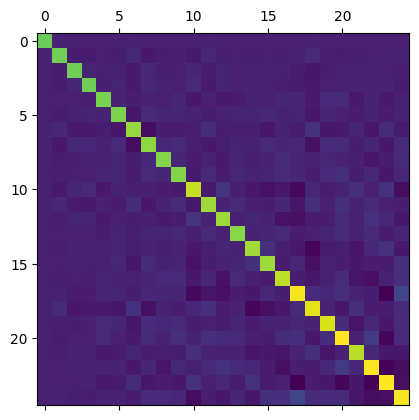

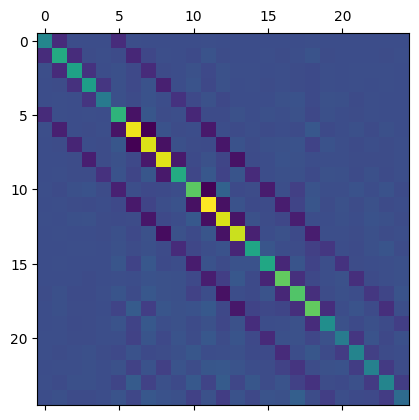

In [31]:
plt.matshow(actor_out.detach().cpu()[0])
plt.matshow(actor_out.detach().cpu()[0] @ A[0].cpu())
#actor_out.detach().cpu()[0]

In [22]:
inp = torch.concat([A.view(Config.batch_size, Config.n**2), actor_out.view(Config.batch_size, Config.n**2)], dim=1)
ciritic_out = critic(inp)

In [23]:
sarse  = ciritic_out[:, 0].view(32, 1)
niter = ciritic_out[:, 1].view(32, 1)
residuals = ciritic_out[:, 2].view(32, 1)

critic_update = critic_crit(sarse, niter, residuals, A.view(32, 25, 25), actor_out.view(32, 25, 25), b)

ciritic_out, reward_func.forward(A.view(32, 25, 25), actor_out.view(32, 25, 25), b)

(tensor([[2.2786e-02, 1.8078e-10, 3.1540e-01],
         [2.1226e-02, 1.7281e-10, 3.1114e-01],
         [2.3047e-02, 2.3490e-10, 3.1708e-01],
         [2.3578e-02, 7.0074e-10, 3.4899e-01],
         [2.0535e-02, 1.6429e-10, 3.2183e-01],
         [2.5447e-02, 7.9799e-10, 3.4344e-01],
         [2.2772e-02, 3.9662e-10, 3.2759e-01],
         [2.2811e-02, 2.5692e-10, 3.1902e-01],
         [2.1832e-02, 2.3119e-10, 3.2196e-01],
         [2.4114e-02, 2.2231e-10, 3.1547e-01],
         [2.0302e-02, 1.0522e-10, 3.1500e-01],
         [2.3914e-02, 4.5853e-10, 3.3198e-01],
         [2.0744e-02, 3.0195e-10, 3.3645e-01],
         [2.4302e-02, 6.2385e-10, 3.4304e-01],
         [2.4534e-02, 4.9627e-10, 3.3209e-01],
         [2.3611e-02, 2.8396e-10, 3.1705e-01],
         [2.8066e-02, 6.3784e-10, 3.2198e-01],
         [2.5270e-02, 5.4362e-10, 3.2206e-01],
         [2.4609e-02, 4.9375e-10, 3.2834e-01],
         [2.1310e-02, 1.1068e-10, 3.0907e-01],
         [2.6878e-02, 4.3258e-10, 3.1466e-01],
         [2.7